# Part 1: Setup and Data Pre-Preprocessing
Note: To run this notebook, you need to create a folder in the same folder as this notebook, called "sample_data". This "sample_data" folder should have the "proj1.csv" and "proj1_no_headers.csv" files.

In [1]:
from typing import *  # type: ignore

import pyspark  # type: ignore
from pyspark.rdd import RDD, PipelinedRDD  # type: ignore

sc: pyspark.SparkContext = pyspark.SparkContext(appName="relevantAnswerClassifier")

## Build RDD (Resilient Distributed Datasets) From Data

In [2]:
fileName = "sample_data/proj1_no_headers.csv"

SOF_RDD: RDD = sc.textFile(fileName, 8)

In [3]:
numPoints: int = SOF_RDD.count()
print("Number of points in dataset: ", numPoints)
samplePoints: List[Any] = SOF_RDD.take(1)
print("Data of sample point: ", samplePoints)

Number of points in dataset:  263540
Data of sample point:  ['563355,62701,0,1235000081,"php,error,gd,image-processing",220,2,563372,67183,2,1235000501']


## Data Description

## Description of the Original Dataset
|Column|Description|
|---|---|
|qid|Unique question id|
|id|User id of questioner|
|qs|Score of the question|
|qt|Time of the question (in epoch time)|
|tags|Comma-separated list of the tags associated with the question. Examples of tags are ``html'', ``R'', ``mysql'', ``python'', and so on; often between two and six tags are used on each question.|
|qvc|Number of views of this question (at the time of the datadump)|
|qac|Number of answers for this question (at the time of the datadump)|
|aid|Unique answer id|
|j|User id of answerer|
|as|Score of the answer|
|at|Time of the answer|

In [4]:
SOF_RDD

sample_data/proj1_no_headers.csv MapPartitionsRDD[1] at textFile at <unknown>:0

## Create Dictionary Which Assigns Unique IDs to Each Combination of Tags

In [5]:
def get_tags(SOF_RDDRecord: str) -> str:
    """
    Joins tags with a character for later assigning a unique ID to each unique combination of tags.

    Parameters
    ----------
    SOF_RDDRecord : str
        A record of an answer to a question on Stack Overflow.

    Returns
    -------
    str
        The record of the answer, but with each tag joined together by a character.
    """

    fieldsList: List[Any] = SOF_RDDRecord.split(",")

    index: int = 4

    tags: str = ""

    while 1:

        if fieldsList[index].replace(".", "", 1).isdigit():

            tags = tags[:-1]

            break

        tags += fieldsList[index] + "_"

        index += 1

    return tags


# Create dictionary of unique IDs for each unique combination of tags.
dictionary: RDD = SOF_RDD.map(get_tags).distinct().zipWithIndex().collectAsMap()

## Create RDD With First Field as Label and Subsequent Fields as Features

In [6]:
def map_SOF(SOF_RDDRecord: str) -> str:
    """
    Pre-processes and performs feature engineering on a raw record of an answer to a Stack Overflow question.

    The pre-procecssing only keeps relevant features, and the feature engineering transforms raw features into new features.

    Parameters
    ----------
    SOF_RDDRecord : str
        The raw record of an answer to a Stack Overflow question.

    Returns
    -------
    str
        The pre-processesed and feature engineered record of the provided answer to a Stack Overflow question.
    """

    fieldsList: List[Any] = SOF_RDDRecord.split(",")
    # qid = fieldsList[2]
    qs: str = fieldsList[2]  # score of question
    qt: str = fieldsList[3]  # time of the question
    tags: str = ""

    index: int = 4
    while 1:
        if fieldsList[index].replace(".", "", 1).isdigit():
            tags = tags[:-1]
            break
        tags += fieldsList[index] + "_"
        index += 1
    num_tags: int = index - 4  # number of tags
    qvc: str = fieldsList[index]  # number of views of this question
    qac: str = fieldsList[index + 1]  # number of answers for this question
    aid: str = fieldsList[index + 2]  # unique answer id
    j: str = fieldsList[index + 3]  # User id of answerer
    ans_score: str = fieldsList[index + 4]  # score of the answer
    at: str = fieldsList[index + 5]  # time of the answer

    isAnswered: str = "0"
    if int(ans_score) > 0:
        isAnswered = "1"

    deltaTimeQToA: int = abs(int(qt) - int(at))
    tag_indexer = str(dictionary[tags])
    result: str = ",".join(
        [isAnswered, j, qs, qvc, qac, str(deltaTimeQToA), tag_indexer]
    )
    return result


SOF_RDD_BinAnsScor: RDD = SOF_RDD.map(map_SOF)

## Filter Non-Numeric Values

In [7]:
num_indices: List[int] = [0, 1, 2, 3, 4, 5, 6]


def filter_non_numeric(line: str) -> bool:
    """
    Returns true if all features of the record provided at the numeric indices are indeed numeric.

    Parameters
    ----------
    line : str
        The raw record of the RDD.

    Returns
    -------
    bool
        True if specified features are numeric, False otherwise.
    """
    line_lst: List[str] = [val.strip() for val in line.split(",")]
    for i in num_indices:
        if not line_lst[i].replace(".", "", 1).isdigit():
            return False
    return True


SOF_RDD_BinAnsScor = SOF_RDD.map(map_SOF).filter(filter_non_numeric)

In [8]:
print("First few filtered points: ", SOF_RDD_BinAnsScor.take(10))

print("Number of filtered points: ", SOF_RDD_BinAnsScor.count())

First few filtered points:  ['1,67183,0,220,2,420,49250', '0,66554,0,220,2,470,49250', '1,15842,10,1047,16,37,41190', '1,893,10,1047,16,1405,41190', '1,11649,10,1047,16,2317,41190', '1,50742,10,1047,16,2669,41190', '1,8899,10,1047,16,3126,41190', '1,60190,10,1047,16,7677,41190', '1,65235,10,1047,16,7773,41190', '1,32797,10,1047,16,20486,41190']
Number of filtered points:  258488


## Parse RDD Into RDD of Labeled Points

In [9]:
import numpy as np  # type: ignore
from pyspark.mllib.linalg import DenseVector  # type: ignore
from pyspark.mllib.regression import LabeledPoint  # type: ignore


def parsePoint(line: str) -> LabeledPoint:
    """
    Parses a record of features and its label into a Labeled Point.

    Parameters
    ----------
    line : str
        The raw record of features and its label.

    Returns
    -------
    LabeledPoint
        The Labeled Point representing the record of the answer to a Stack Overflow question.
    """
    label_features: List[str] = line.split(",")
    ret_val: LabeledPoint = LabeledPoint(label_features[0], label_features[1:])
    return ret_val


parsedSamplePoints: RDD = SOF_RDD_BinAnsScor.map(parsePoint)

firstPoint: LabeledPoint = parsedSamplePoints.take(1)[0]
firstPointFeatures: DenseVector = firstPoint.features
firstPointLabel: float = firstPoint.label
d: int = len(firstPointFeatures)

print("First point: ", firstPoint)
print("First point features: ", firstPointFeatures)
print("First point label: ", firstPointLabel)
print("Number of first point features: ", d)

First point:  (1.0,[67183.0,0.0,220.0,2.0,420.0,49250.0])
First point features:  [67183.0,0.0,220.0,2.0,420.0,49250.0]
First point label:  1.0
Number of first point features:  6


## Apply Feature Scaling

In [10]:
from pyspark.broadcast import Broadcast  # type: ignore


# Feature Scaling
def normalizeFeatures(lp: LabeledPoint) -> LabeledPoint:
    """
    Normalizes a labeled point.

    Parameters
    ----------
    lp : Labeled Point
        The unnormalized labeled point.

    Returns
    -------
    LabeledPoint
        The normalized labeled point.
    """
    normalizedFeatures: List[float] = list()
    for i in range(0, len(lp.features)):
        feature: float = (lp.features[i] - broadcastMean.value[i]) / broadcastStdev.value[i]  # type: ignore
        normalizedFeatures.insert(i, feature)
    return LabeledPoint(lp.label, normalizedFeatures)


def getNormalizedRDD(nonNormalizedRDD: RDD) -> RDD:
    """
    Normalizes the labeled points of an RDD.

    Parameters
    ----------
    nonNormalizedRDD : RDD
        The nonnormalized RDD of labeled points.

    Returns
    -------
    RDD
        The normalized RDD of labeled points.
    """
    meanList: List[float] = list()
    stdevList: List[float] = list()
    numFeatures: int = len(nonNormalizedRDD.take(1)[0].features)
    for i in range(0, numFeatures):
        featureRDD: RDD = nonNormalizedRDD.map(lambda lp: lp.features[i])
        print(featureRDD)
        featureMean: float = featureRDD.mean()
        featureStdev: float = featureRDD.stdev()
        meanList.insert(i, featureMean)
        stdevList.insert(i, featureStdev)
    global broadcastMean  # type: ignore
    broadcastMean = sc.broadcast(meanList)  # type: ignore
    global broadcastStdev  # type: ignore
    broadcastStdev = sc.broadcast(stdevList)  # type: ignore
    returnRDD: RDD = nonNormalizedRDD.map(normalizeFeatures)
    return returnRDD


normalizedSamplePoints: RDD = getNormalizedRDD(parsedSamplePoints)
print("First few normalized sample points: ", normalizedSamplePoints.take(5))

PythonRDD[14] at RDD at PythonRDD.scala:53
PythonRDD[17] at RDD at PythonRDD.scala:53
PythonRDD[20] at RDD at PythonRDD.scala:53
PythonRDD[23] at RDD at PythonRDD.scala:53
PythonRDD[26] at RDD at PythonRDD.scala:53
PythonRDD[29] at RDD at PythonRDD.scala:53
First few normalized sample points:  [LabeledPoint(1.0, [0.5893728470612627,-0.3258285416359602,-0.06382492744499169,-0.4305735260437117,-0.05525310597553529,0.9041167352507555]), LabeledPoint(0.0, [0.5703616653440576,-0.3258285416359602,-0.06382492744499169,-0.4305735260437117,-0.05523326507086109,0.9041167352507555]), LabeledPoint(1.0, [-0.9623808580945783,0.8813132845596168,1.2030468466079869,1.081128496481659,-0.05540508730533966,0.47569574514370194]), LabeledPoint(1.0, [-1.414206224534162,0.8813132845596168,1.2030468466079869,1.081128496481659,-0.05486224015345355,0.47569574514370194]), LabeledPoint(1.0, [-1.0891119947245318,0.8813132845596168,1.2030468466079869,1.081128496481659,-0.054500342052196143,0.47569574514370194])]


## Split Dataset Into Training and Validation Datasets
### Each Dataset Will Be Cached for Repeated Future Use

In [11]:
weights: List[float] = [0.8, 0.2]  # train/test split
seed: int = 42
parsedTrainData: RDD
parsedValData: RDD
parsedTrainData, parsedValData = normalizedSamplePoints.randomSplit(weights, seed)
parsedTrainData.cache()
parsedValData.cache()
nTrain: int = parsedTrainData.count()
nVal: int = parsedValData.count()

print("Number of Train Points: ", nTrain)
print("Number of Validation Points: ", nVal)
print("Number of Train and Validation Points: ", nTrain + nVal)
print("Number of Normalized Sample Points: ", normalizedSamplePoints.count())

Number of Train Points:  206810
Number of Validation Points:  51678
Number of Train and Validation Points:  258488
Number of Normalized Sample Points:  258488


# Part 2: Create, Train, and Evaluate Baseline Model

## Create Average (Mean) Label Baseline Model
A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value. This value is rounded to the nearest integer to allow for binary classification (1 or 0).

In [12]:
averageScore: float = int(round((parsedTrainData.map(lambda s: s.label)).mean()))
print("Average (mean) score: ", averageScore)

Average (mean) score:  1


## Calculate Root Mean Squared Error (RMSE)
Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [35]:
import math


def squaredError(label: float, prediction: float) -> float:
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.

    :Authors:
        Dr. Diwakar Krishnamurthy <dkrishna@ucalgary.ca>
    """
    sqrError: float = (label - prediction) * (label - prediction)
    return sqrError


def calcRMSE(labelsAndPreds: RDD) -> float:
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.

    :Authors:
        Dr. Diwakar Krishnamurthy <dkrishna@ucalgary.ca>
    """
    sqrSum = labelsAndPreds.map(lambda s: squaredError(s[0], s[1])).sum()
    return math.sqrt(sqrSum / labelsAndPreds.count())

## Create Evaluation Metrics Dataframes for Training and Validation Datasets

In [36]:
import pandas as pd  # type: ignore


def evaluationMetricsDataframe() -> pd.DataFrame:
    """Creates a Pandas DataFrame from storing evaluation metrics.

    Returns
    -------
    pd.DataFrame
        The DataFrame of evaluation metrics.
    """
    columns: List[str] = ["RMSE", "Accuracy", "Precision", "Recall", "F_Score"]

    evaluationMetrics: pd.DataFrame = pd.DataFrame(
        index=[
            "Baseline",
            "Gradient_Boosted_Trees",
            "SVM_With_SGD",
            "Random_Forest",
            "Logistic_Regression",
            "Decision_Tree",
        ],
        columns=columns,
    )

    return evaluationMetrics

In [37]:
evaluationMetricsTrain: pd.DataFrame = evaluationMetricsDataframe()

evaluationMetricsTrain

,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,NaN,NaN,NaN,NaN,NaN
Gradient_Boosted_Trees,NaN,NaN,NaN,NaN,NaN
SVM_With_SGD,NaN,NaN,NaN,NaN,NaN
Random_Forest,NaN,NaN,NaN,NaN,NaN
Logistic_Regression,NaN,NaN,NaN,NaN,NaN
Decision_Tree,NaN,NaN,NaN,NaN,NaN


In [38]:
evaluationMetricsVal: pd.DataFrame = evaluationMetricsDataframe()

evaluationMetricsVal

,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,NaN,NaN,NaN,NaN,NaN
Gradient_Boosted_Trees,NaN,NaN,NaN,NaN,NaN
SVM_With_SGD,NaN,NaN,NaN,NaN,NaN
Random_Forest,NaN,NaN,NaN,NaN,NaN
Logistic_Regression,NaN,NaN,NaN,NaN,NaN
Decision_Tree,NaN,NaN,NaN,NaN,NaN


## Create RDD of Baseline Model Labels and Predictions

In [39]:
labelsAndPredsTrain: RDD = parsedTrainData.map(lambda s: (s.label, averageScore))
labelsAndPredsVal: RDD = parsedValData.map(lambda s: (s.label, averageScore))

## Create Functions for Calculating Evaluation Metrics

In [40]:
def calcConfusionMatrixMetrics(
    labelsAndPreds: RDD,
) -> Tuple[int, ...]:
    """
    Calculates confusion matrix metrics.

    Parameters
    ----------
    labelsAndPreds: RDD
        The RDD of labels and predictions.

    Returns
    -------
    Tuple[int, ...]
        The tuple of confusion matrix metrics.
    """
    # true positives
    TP: int = labelsAndPreds.filter(lambda lp: (lp[0] == 1) and (lp[1] == 1)).count()
    # true negatives
    TN: int = labelsAndPreds.filter(lambda lp: (lp[0] == 0) and (lp[1] == 0)).count()
    # false positives
    FP: int = labelsAndPreds.filter(lambda lp: (lp[0] == 0) and (lp[1] == 1)).count()
    # false negative
    FN: int = labelsAndPreds.filter(lambda lp: (lp[0] == 1) and (lp[1] == 0)).count()
    return TP, TN, FP, FN

In [41]:
def calcAccuracy(TP: int, TN: int, FP: int, FN: int) -> float:
    """
    Calculates accuracy.

    Parameters
    ----------
    TP : int
        Number of true positives.
    TN : int
        Number of true negatives.
    FP : int
        Number of false positives.
    FN : int
        Number of false negatives.

    Returns
    -------
    float
        Accuracy metric.
    """
    accuracy: float = (TP + TN) / (TP + FP + TN + FN)
    return accuracy


def calcPrecision(TP: int, FP: int) -> float:
    """
    Calculates precision.

    Parameters
    ----------
    TP : int
        Number of true positives.
    FP : int
        Number of false positives.

    Returns
    -------
    float
        Precision metric.
    """
    precision: float = TP / (TP + FP)
    return precision


def calcRecall(TP: int, FN: int) -> float:
    """
    Calculates precision.

    Parameters
    ----------
    TP : int
        Number of true positives.
    FN : int
        Number of false negatives.

    Returns
    -------
    float
        Recall metric.
    """
    recall: float = (TP) / (TP + FN)
    return recall


def calcFScore(precision: float, recall: float) -> float:
    """
    Calculates f-score.

    Parameters
    ----------
    precision : float
        Precision metric.
    recall : float
        Recall metric.

    Returns
    -------
    float
        F-Score metric.
    """
    fScore: float = (2 * precision * recall) / (precision + recall)
    return fScore

In [42]:
# calculate confusion matrix metrics
def calcEvaluationMetrics(
    evaluationMetrics: pd.DataFrame, model_name: str, labelsAndPreds: RDD
) -> None:
    """
    Calculates evaluation metrics for evaluation DataFrame.

    Parameters
    ----------
    evaluationMetrics : pd.DataFrame
        The DataFrame of evaluation metrics.
    labelsAndPreds : RDD
        The RDD of labels and predictions.

    Returns
    ------
    None
    """
    # RMSE
    evaluationMetrics["RMSE"][model_name] = calcRMSE(labelsAndPreds)

    # Confusion Matrix
    TP: int
    TN: int
    FP: int
    FN: int
    TP, TN, FP, FN = calcConfusionMatrixMetrics(labelsAndPreds)

    # Accuracy
    evaluationMetrics["Accuracy"][model_name] = calcAccuracy(TP, TN, FP, FN)

    # Precision
    evaluationMetrics["Precision"][model_name] = calcPrecision(TP, FP)

    # Recall
    evaluationMetrics["Recall"][model_name] = calcRecall(TP, FN)

    # F-Score
    evaluationMetrics["F_Score"][model_name] = calcFScore(
        evaluationMetrics["Precision"][model_name],
        evaluationMetrics["Recall"][model_name],
    )

## Calculate Evaluation Metrics of Baseline Model

In [43]:
calcEvaluationMetrics(evaluationMetricsTrain, "Baseline", labelsAndPredsTrain)

calcEvaluationMetrics(evaluationMetricsVal, "Baseline", labelsAndPredsVal)

In [44]:
print("Model Train Data Evaluation Metrics")
evaluationMetricsTrain

Model Train Data Evaluation Metrics


,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,0.630012,0.603085,0.603085,1,0.752405
Gradient_Boosted_Trees,NaN,NaN,NaN,NaN,NaN
SVM_With_SGD,NaN,NaN,NaN,NaN,NaN
Random_Forest,NaN,NaN,NaN,NaN,NaN
Logistic_Regression,NaN,NaN,NaN,NaN,NaN
Decision_Tree,NaN,NaN,NaN,NaN,NaN


Explanation for recall being 1: The baseline model is just the mean value of the labels rounded to the nearest integer. In the case of this data set, that mean value rounded up to 1. Therefore, the baseline model will never have a false negative due it always classifying a sample as "relevant" (i.e., the label is always 1). This results in the Recall just being equivalent to TP (Number of true positives) over TP, which is just 1.

In [45]:
print("Model Validation Data Evaluation Metrics")

evaluationMetricsVal

Model Validation Data Evaluation Metrics


,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,0.62937,0.603893,0.603893,1,0.753034
Gradient_Boosted_Trees,NaN,NaN,NaN,NaN,NaN
SVM_With_SGD,NaN,NaN,NaN,NaN,NaN
Random_Forest,NaN,NaN,NaN,NaN,NaN
Logistic_Regression,NaN,NaN,NaN,NaN,NaN
Decision_Tree,NaN,NaN,NaN,NaN,NaN


Explanation for recall being 1: We again see the baseline model has recall of 1, because it always classifies every sample as having a label of 1, thus there are no false positives.

# Part 3: Train Other Models by Using MLlib

## Create and Fit Other Models

In [46]:
from pyspark.mllib.classification import (  # type: ignore
    LogisticRegressionModel, LogisticRegressionWithLBFGS, SVMModel, SVMWithSGD)
from pyspark.mllib.tree import DecisionTree  # type: ignore
from pyspark.mllib.tree import (DecisionTreeModel, GradientBoostedTrees,
                                GradientBoostedTreesModel, RandomForest,
                                RandomForestModel)
from pyspark.mllib.util import MLUtils  # type: ignore

# Train a GradientBoostedTrees model.
#  Notes: (a) Empty categoricalFeaturesInfo indicates all features are continuous.
#         (b) Using iterations.
modelGradientBoostedTrees: GradientBoostedTrees = GradientBoostedTrees.trainClassifier(
    parsedTrainData, categoricalFeaturesInfo={}, numIterations=3
)

SVMWithSGDModel: SVMWithSGD = SVMWithSGD.train(parsedTrainData, iterations=10)

modelRandomForest: RandomForest = RandomForest.trainClassifier(
    parsedTrainData,
    categoricalFeaturesInfo={},
    numTrees=8,
    featureSubsetStrategy="auto",
    maxDepth=5,
    maxBins=32,
    numClasses=3,
)

modelLogisticRegression: LogisticRegressionWithLBFGS = (
    LogisticRegressionWithLBFGS.train(parsedTrainData)
)

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
decisionTree: DecisionTree = DecisionTree.trainClassifier(
    parsedTrainData, categoricalFeaturesInfo={}, numClasses=3
)

## Create RDD of Labels and Predictions of Other Models

In [47]:
# Evaluate model on test instances and compute test error
samplePoint: LabeledPoint = parsedTrainData.take(1)[0]
samplePrediction: float = modelGradientBoostedTrees.predict(samplePoint.features)

print("samplePoint: ", samplePoint)
print("sample label: ", samplePoint.label)
print("sample features: ", samplePoint.features)
print("sample prediction: ", samplePrediction)

samplePoint:  (1.0,[0.5893728470612627,-0.3258285416359602,-0.06382492744499169,-0.4305735260437117,-0.05525310597553529,0.9041167352507555])
sample label:  1.0
sample features:  [0.5893728470612627,-0.3258285416359602,-0.06382492744499169,-0.4305735260437117,-0.05525310597553529,0.9041167352507555]
sample prediction:  1.0


## Calculate Evaluation Metrics of Other Models

In [48]:
MODEL_NAMES: List[str] = [
    "Gradient_Boosted_Trees",
    "SVM_With_SGD",
    "Random_Forest",
    "Logistic_Regression",
    "Decision_Tree",
]
MODELS: list = [
    modelGradientBoostedTrees,
    SVMWithSGDModel,
    modelRandomForest,
    modelLogisticRegression,
    decisionTree,
]
for modelName, model in zip(MODEL_NAMES, MODELS):
    print(f"{'Training and evaluating: ':<30}{modelName:>30}")
    predsTrain: RDD = model.predict(parsedTrainData.map(lambda x: x.features))
    predsVal: RDD = model.predict(parsedValData.map(lambda x: x.features))

    labelsAndPredsTrain = parsedTrainData.map(lambda lp: lp.label).zip(predsTrain)
    labelsAndPredsVal = parsedValData.map(lambda lp: lp.label).zip(predsVal)

    calcEvaluationMetrics(evaluationMetricsTrain, modelName, labelsAndPredsTrain)
    calcEvaluationMetrics(evaluationMetricsVal, modelName, labelsAndPredsVal)
    print(f"{'Done training and evaluating: ':<30}{modelName:>30}")

Training and evaluating:              Gradient_Boosted_Trees
Done training and evaluating:         Gradient_Boosted_Trees
Training and evaluating:                        SVM_With_SGD
Done training and evaluating:                   SVM_With_SGD
Training and evaluating:                       Random_Forest
Done training and evaluating:                  Random_Forest
Training and evaluating:                 Logistic_Regression
Done training and evaluating:            Logistic_Regression
Training and evaluating:                       Decision_Tree
Done training and evaluating:                  Decision_Tree


In [49]:
print("Model Training Data Evaluation Metrics")

evaluationMetricsTrain

Model Training Data Evaluation Metrics


,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,0.630012,0.603085,0.603085,1,0.752405
Gradient_Boosted_Trees,0.59268,0.648731,0.659555,0.86301,0.747689
SVM_With_SGD,0.670047,0.551037,0.649497,0.555138,0.598622
Random_Forest,0.592353,0.649118,0.651092,0.901037,0.75594
Logistic_Regression,0.649165,0.578584,0.662399,0.61434,0.637465
Decision_Tree,0.591843,0.649722,0.660971,0.860628,0.7477


In [50]:
print("Model Validation Data Evaluation Metrics")
evaluationMetricsVal

Model Validation Data Evaluation Metrics


,RMSE,Accuracy,Precision,Recall,F_Score
Baseline,0.62937,0.603893,0.603893,1,0.753034
Gradient_Boosted_Trees,0.594019,0.647142,0.658699,0.862695,0.747021
SVM_With_SGD,0.669259,0.552092,0.651848,0.554409,0.599193
Random_Forest,0.593481,0.64778,0.650518,0.90057,0.755389
Logistic_Regression,0.648555,0.579376,0.663989,0.614394,0.638229
Decision_Tree,0.593611,0.647626,0.659979,0.859107,0.746492


## Visualizations of Model Evaluation Metrics

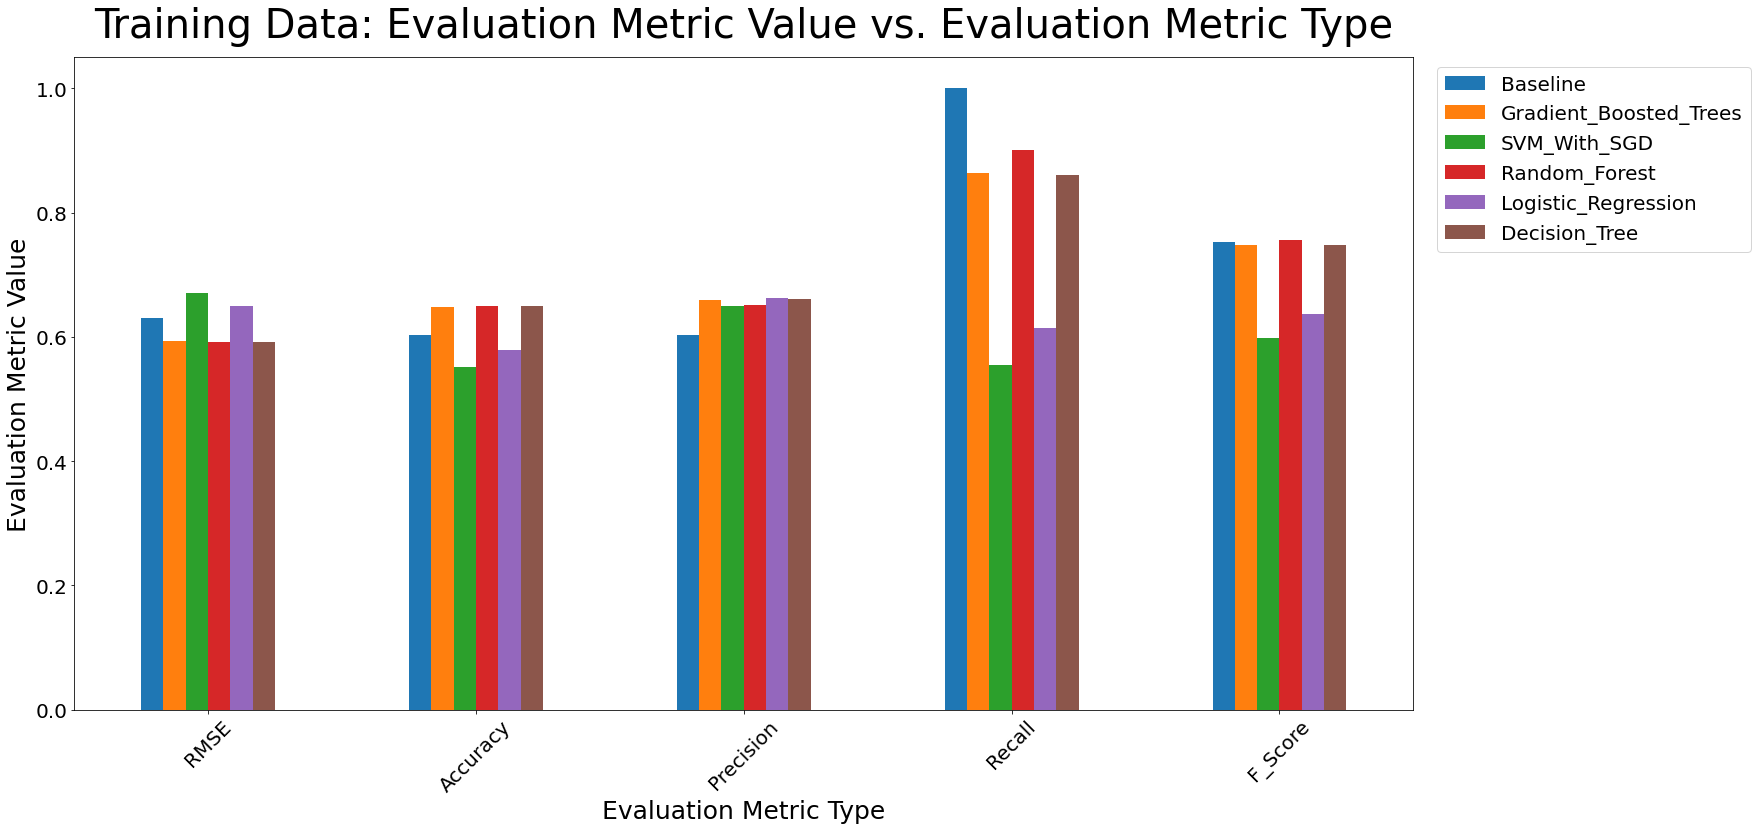

In [52]:
import matplotlib.pyplot as plt  # type: ignore

fig = evaluationMetricsTrain.T.plot.bar(figsize=(24, 12), rot=45)

fig.set_title(
    "Training Data: Evaluation Metric Value vs. Evaluation Metric Type",
    fontsize=40,
    pad=20,
)

fig.set_xlabel("Evaluation Metric Type", fontsize=25)

fig.set_ylabel("Evaluation Metric Value", fontsize=25)

fig.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=20)

plt.xticks(size=20)

plt.yticks(size=20)

plt.show()

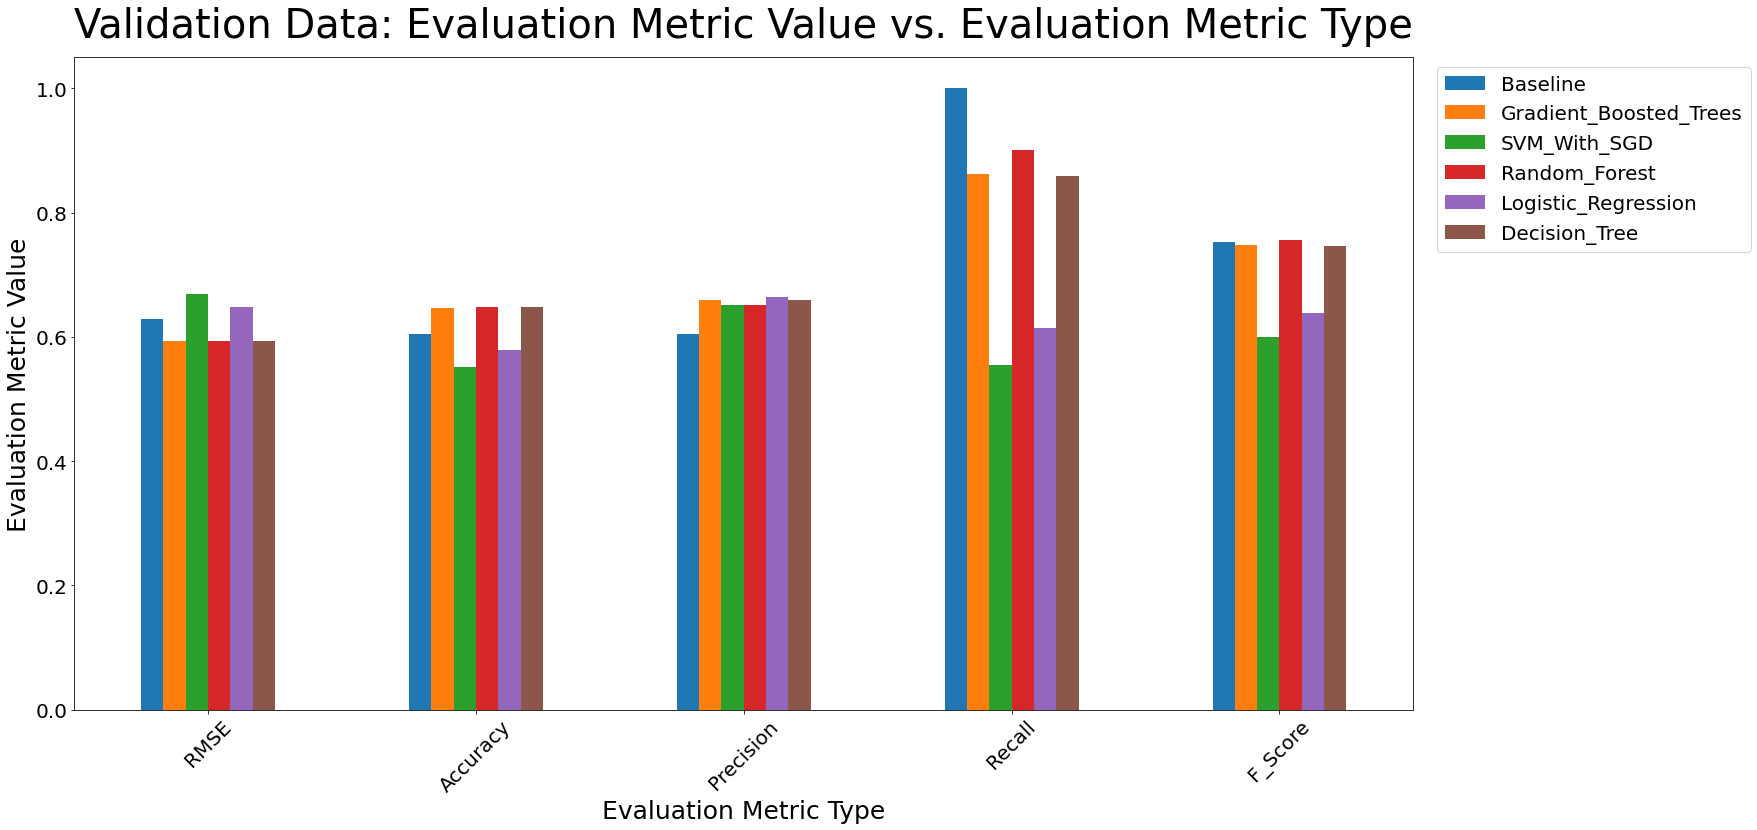

In [53]:
fig = evaluationMetricsVal.T.plot.bar(figsize=(24, 12), rot=45)

fig.set_title(
    "Validation Data: Evaluation Metric Value vs. Evaluation Metric Type",
    fontsize=40,
    pad=20,
)

fig.set_xlabel("Evaluation Metric Type", fontsize=25)

fig.set_ylabel("Evaluation Metric Value", fontsize=25)

fig.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=20)

plt.xticks(size=20)

plt.yticks(size=20)

plt.show()

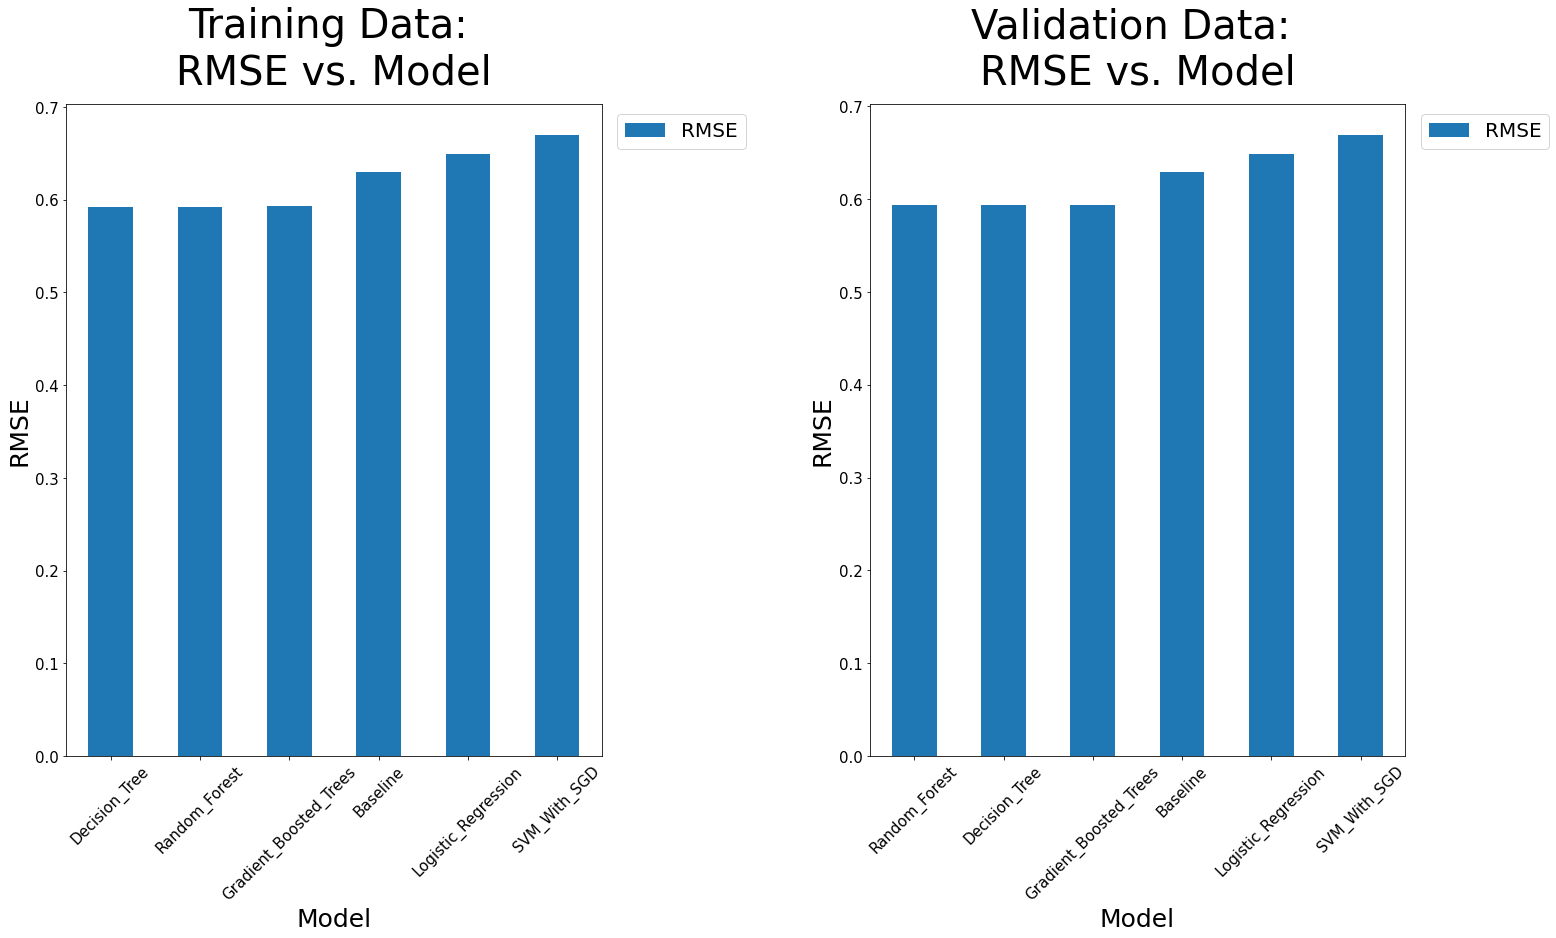

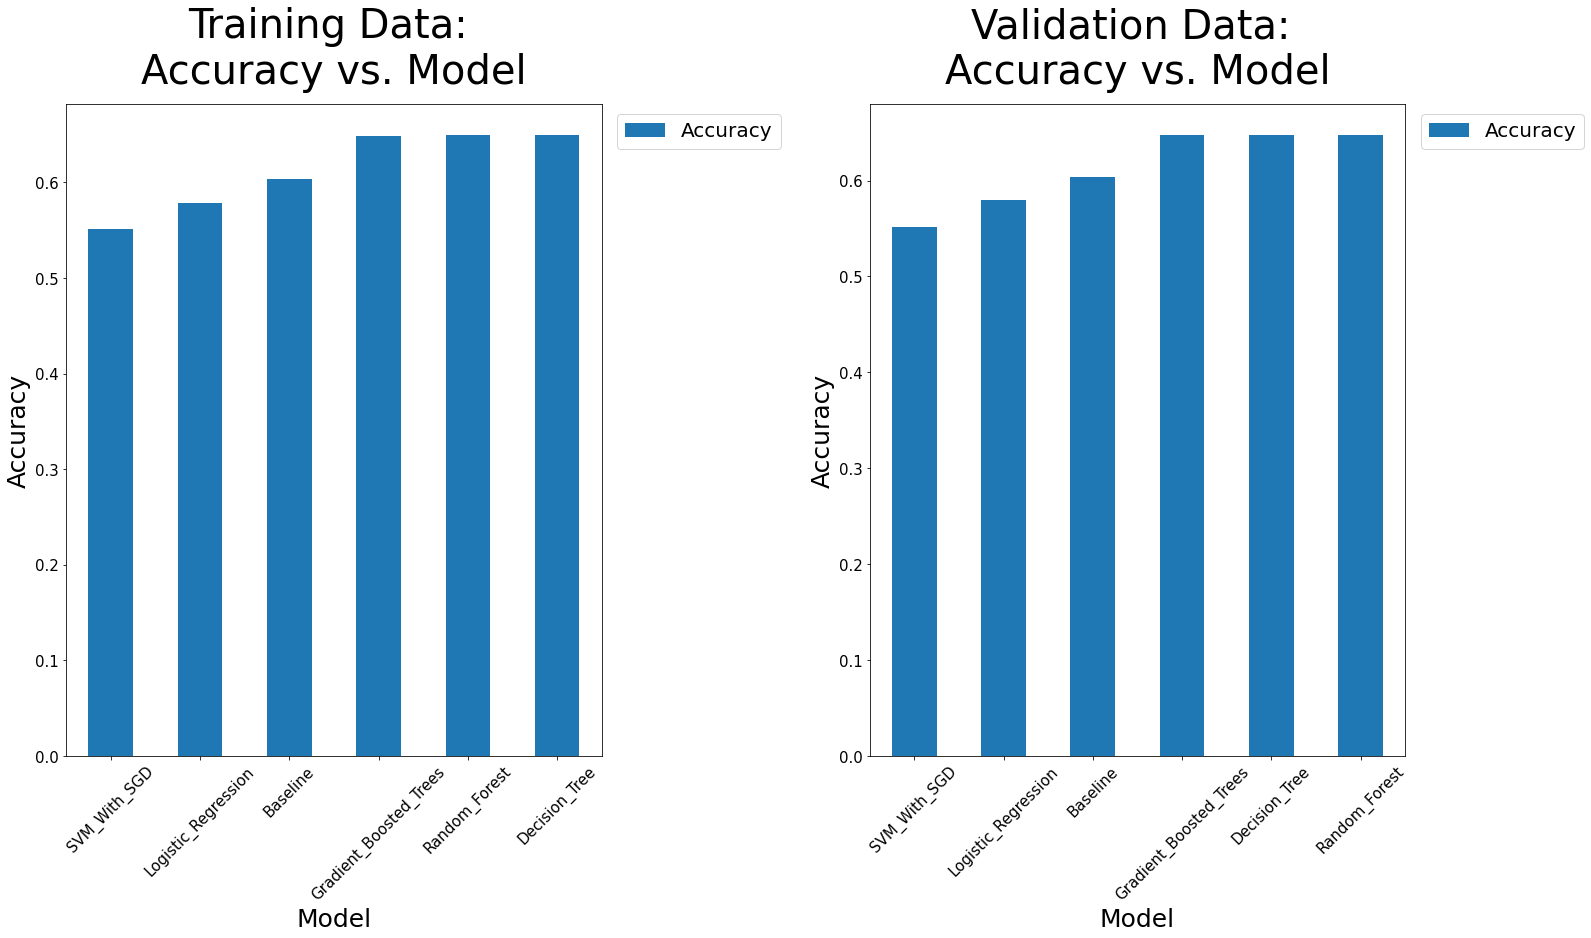

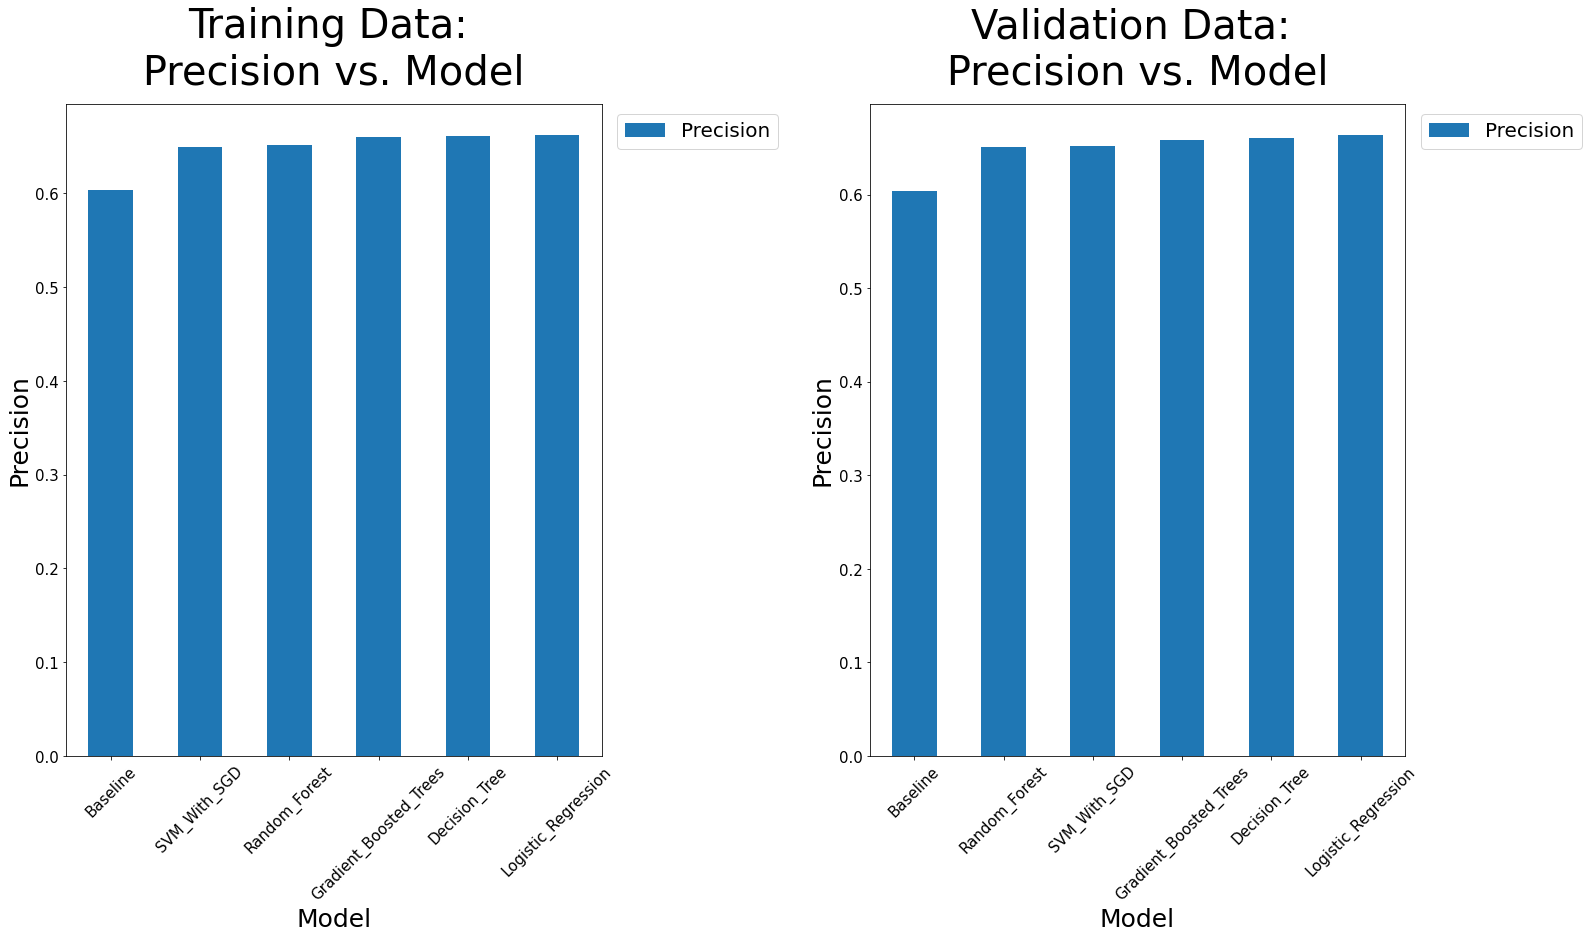

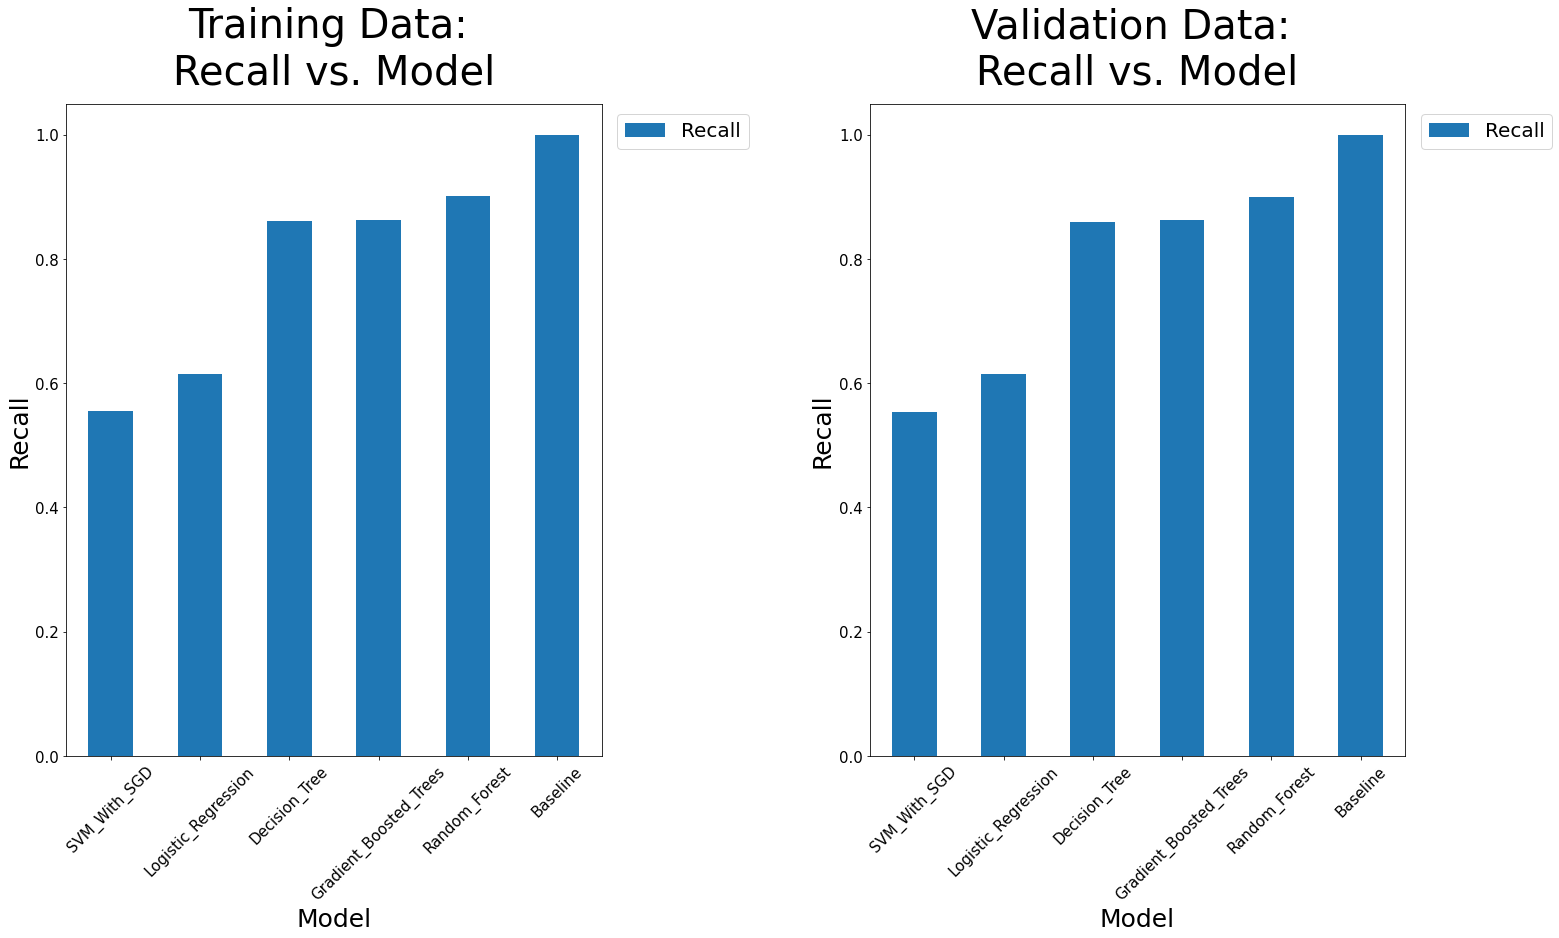

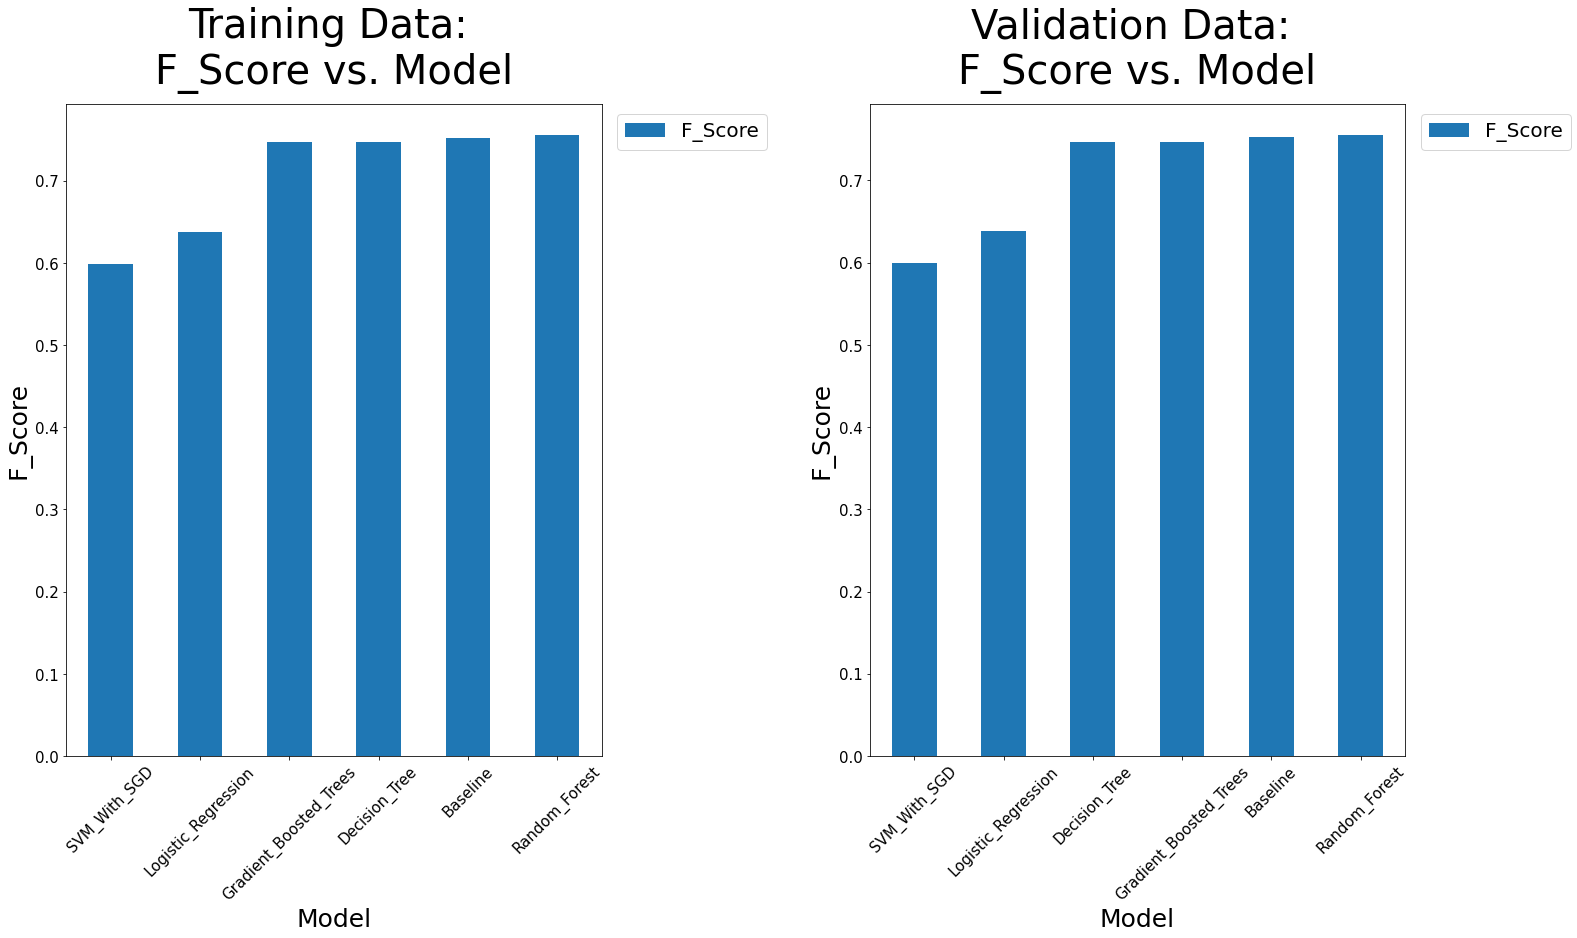

In [54]:
for col in evaluationMetricsTrain.columns:

    fig, axes = plt.subplots(nrows=1, ncols=2)

    plt.subplots_adjust(wspace=0.5)

    fig1 = evaluationMetricsTrain.sort_values(by=[col])[col].plot.bar(
        figsize=(24, 12), rot=45, ax=axes[0]
    )

    fig1.set_title(f"Training Data: \n{col} vs. Model", fontsize=40, pad=20)

    fig1.set_ylabel(f"{col}", fontsize=25)

    fig1.set_xlabel("Model", fontsize=25)

    fig1.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=20)

    plt.sca(axes[0])

    plt.xticks(size=15)

    plt.yticks(size=15)

    fig2 = evaluationMetricsVal.sort_values(by=[col])[col].plot.bar(
        figsize=(24, 12), rot=45, ax=axes[1]
    )

    fig2.set_title(f"Validation Data: \n{col} vs. Model", fontsize=40, pad=20)

    fig2.set_ylabel(f"{col}", fontsize=25)

    fig2.set_xlabel("Model", fontsize=25)

    fig2.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=20)

    plt.sca(axes[1])

    plt.xticks(size=15)

    plt.yticks(size=15)

    plt.show()